# Modélisation de bruit corrélé autour d'un modèle physique avec les processus gaussiens

Tel que vu en classe, un processus gaussien permet de modéliser le bruit corrélé autour d'un modèle paramétrique (souvent appelé "mean function" dans la litérature).
Nous allons effectuer une telle analyse avec un modèle assez similaire à celui utilisé dans le devoir 1.

Pour couvrir du même coup les GPs et le HMC, nous allons utilisé la librarie `tinygp`, qui utilise `jax` afin de facilement calculer le gradient des modèles GPs.
Pour l'échantillonage HMC, nous allons utiliser NumPyro, une librairie de programmation probabilistique (PPL).

## Définition du modèle physique
Supposons qu'on cherche l'amplitude, la largeur et la position d'une raie d'émission. On additionne aussi une constante pour modéliser le niveau du continuum. Notre modèle sera donc

$$
m(x) = b + a \exp{\left(-\frac{(x-\ell)^2}{2 w^2}\right)}
$$

Pour que le modèle soit compatible avec `tinygp` et NumPyro, nous allons le créer avec `jax`.

_Note: C'est un hasard qu'on utilise une **gaussienne** comme modèle paramétrique avec notre prorcessus **gaussien**. La fonction paramétrique ("mean function") aurait pu être une droite, un sinus, un transit, etc., selon les données qu'on observe._

In [1]:
from functools import partial
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Précision machine "double" avec Jax
jax.config.update("jax_enable_x64", True)

def gaussian_model(params: dict, X: float):
    """
    Modèle d'une gaussienne et d'un terme constant.
    
    Paramètres
    ----------
    params : dict
        Dictionaire de paramètres avec des éléments "loc", "log_width", "a" et "b".
    X : float
        Valeur(s) X pour laquelle on calcule la fonction.
    """
    # Le modèle de gaussienne
    mod = params["b"] + params["a"] * jnp.exp(-0.5 * jnp.square((X - params["loc"]) / jnp.exp(params["log_width"])))
    return mod

In [2]:
mean_params = {
    "a": 0.3,
    "b": 0.1,
    "loc": 5.0,
    "log_width": np.log(0.5),
}

X_grid = np.linspace(0, 10, num=200)

ymodel = gaussian_model(mean_params, X_grid)

I0000 00:00:1709265952.925135   90620 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


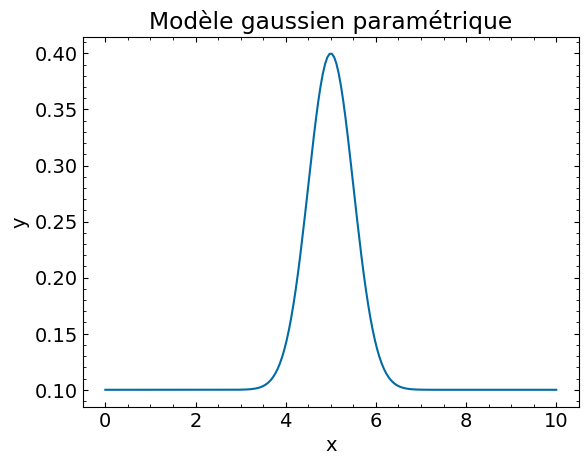

In [3]:
plt.plot(X_grid, ymodel)
plt.title("Modèle gaussien paramétrique")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Données simulées
On peut générer des données simulées à partir de la gaussienne, mais aussi d'un signal additionnel "inconnu" qu'on pourra modéliser avec un GP.

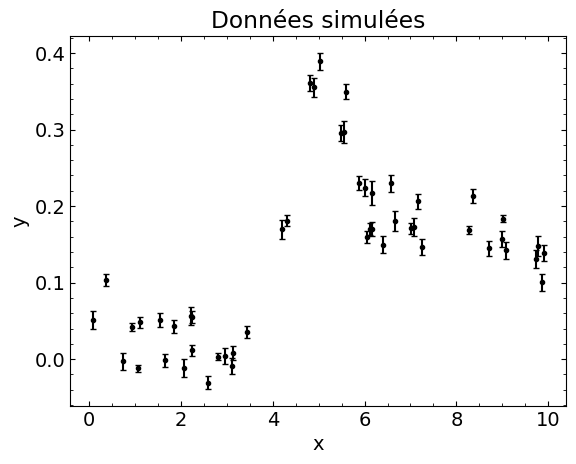

In [4]:
random = np.random.default_rng(135)
X = np.sort(random.uniform(0, 10, 50))
X_test = np.linspace(X.min() - 2.0, X.max() + 2.0, num=200)
y = gaussian_model(mean_params, X)
true_y = gaussian_model(mean_params, X_test)
y += 0.1 * np.sin(2 * np.pi * (X - 5) / 10.0)
true_y += 0.1 * np.sin(2 * np.pi * (X_test - 5) / 10.0)
y += 0.03 * random.normal(size=len(X))
yerr = np.abs(0.003 * random.normal(size=len(X)) + 0.01)

plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.title("Données simulées")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Modèle GP

Il est maintenant temps de définir le modèle GP que nous allons utiliser pour les données.
La fonction "moyenne" reste la même (une gaussienne), mais on ajoute un GP à notre modèle pour s'occuper du signal additionnel.
On utilise un kernel Matern 5/2. En partique, on en testerait probablement quelques uns pour vérifier que le choix est optimal.

On regénère le GP dans une fonction afin de facilement mettre à jour les paramètres à chaque itération d'un optimiseur ou MCMC.

In [5]:
from tinygp import kernels, GaussianProcess

def build_gp(params: dict, X: np.ndarray, yerr: Union[np.ndarray, float] = 0.0) -> GaussianProcess:
    """
    Création d'un modèle GP
    
    Paramètres
    ----------
    params : dict
        Paramètres du modèle dans un dictionaire. Devrait contenir les paramètres log_gp_amp, log_gp_scale et log_gp_diag, en plus des paramètres pour gaussian_model()
    X : np.ndarray
        Coordonées d'entrée X du GP pour le calcul de la vraisemblance
    yerr: Union[np.ndarray, float]
        Erreur sur les mesures. Le carré des erreurs est ajouté à la diagonale.
        Pour générer des échantillons du GP. ce paramètre devrait être 0.0
    """
    
    kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(jnp.exp(params["log_gp_scale"]))
    return GaussianProcess(kernel, X, diag=yerr**2 + jnp.exp(params["log_gp_diag"]), mean=partial(gaussian_model, params))

### Distribution_prior_ du GP
On peut d'abord vérifier de quoi on l'air les échantillons individuels du GP _à priori_, avant d'avoir montré des données au modèle.

In [6]:
params_ini = {
    "log_gp_amp": np.log(0.1),
    "log_gp_scale": np.log(3),
    # Petite valeur pour afficher des prédictions qui ne tiennent pas compte de données.
    # Si on utilisait une grande valeur, il y aurait un bruit "blanc" (gaussien indépendant) sur chacun des points dans l'échantillon prior.
    "log_gp_diag": np.log(1e-8),
    "a": 0.2,
    "b": 0.1,
    "loc": 4.5,
    "log_width": np.log(1.0),
}

In [7]:
gp_sample = build_gp(params_ini, X_test)

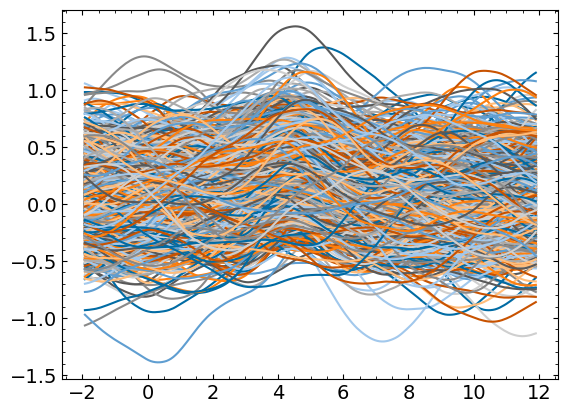

In [8]:
ysamp = gp_sample.sample(jax.random.PRNGKey(4), shape=(1000,))
plt.plot(X_test, ysamp.T)
plt.show()

On peut également vérifier de quoi ont l'air la moyenne et la variance du GP.

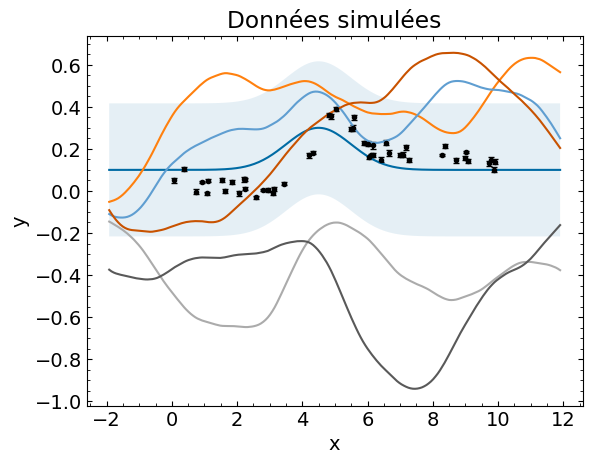

In [9]:
std = np.sqrt(gp_sample.variance)

ysamp = gp_sample.sample(jax.random.PRNGKey(13), shape=(5,))

plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.plot(X_test, gp_sample.mean)
plt.plot(X_test, ysamp.T)
plt.fill_between(X_test, gp_sample.mean - std, gp_sample.mean + std, alpha=0.1)
plt.title("Données simulées")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

On voit que le prior du GP est très incertain autour de la moyenne. En montrant des données au GP, la situation devrait s'améliorer un peu.

### GP conditioné (_posterior_)
Maintenat, _sans modifier les hyperparamètres_, on peut conditionner le GP sur les données. Mêmes si les hyperaparamètres ne sont pas optimaux, on devrait au moins obtenir une prédiction qui ne passe pas trop loin des données.

In [10]:
# Ajout d'un terme de diagonale, qu'on avait initialisé à 0 pour tirer des échantillons
params_ini["log_gp_diag"] = np.log(0.001)
gp = build_gp(params_ini, X, yerr=yerr)

In [11]:
cond, cond_gp = gp.condition(y, X_test)
print(cond)

80.73223957673474


In [12]:
csamp = cond_gp.sample(jax.random.PRNGKey(23), shape=(5,))

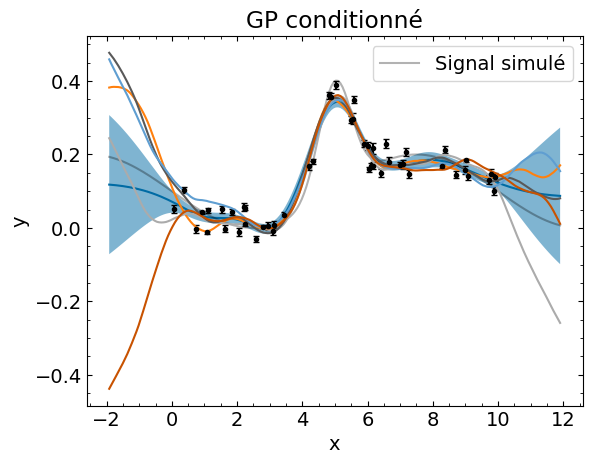

In [13]:
std = np.sqrt(cond_gp.variance)

plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.plot(X_test, cond_gp.mean)
plt.plot(X_test, true_y, "k", lw=1.5, alpha=0.3, label="Signal simulé")
plt.fill_between(X_test, cond_gp.mean - std, cond_gp.mean + std, alpha=0.5)
plt.plot(X_test, csamp.T)
plt.title("GP conditionné")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Déjà beaucoup mieux. Le modèle passe maintenant plus près des données. L'incertitude est également contrainte.
Par contre, on peut tout de même noter un petite écart dans le pic de la gaussienne. Et les échantillons oscillent un peu rapidement, faisant perdre de la capacité d'extrapolation.
De meilleurs hyperparamètres devraient améliorer la situation.

## Optimisation avec Jaxopt

Il existe plusieurs librairies d'optimisation avec Jax. Ici, on utilise Jaxopt, comme dans la documentation de `tinygp` pour ce tutoriel.
Comme Jax calcule automatiquement les gradients, on peut tirer avantage des algorithmes d'optimisation avec gradient.

On doit d'abord définir une "loss function", que l'on souhaite minimiser. Il s'agit ici de la vraisemblance négative (toujours en log).

In [14]:
# jax.jit signifie qu'on souhaite utiliser la compilation "Just in time"
@jax.jit
def loss(params, X, yerr):
    gp = build_gp(params, X, yerr)
    return -gp.log_probability(y)

loss(params_ini, X, yerr)

Array(-80.73223958, dtype=float64)

On peut ensuite chercher le minimum avec une interface similaire à scipy.

In [15]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_util.tree_map(jnp.asarray, params_ini), X, yerr)
print(f"Log-likelihood négatif final: {soln.state.fun_val}")

Log-likelihood négatif final: -99.11292134173867


In [16]:
soln.params

{'a': Array(0.29450945, dtype=float64),
 'b': Array(0.09245199, dtype=float64),
 'loc': Array(5.01954321, dtype=float64),
 'log_gp_amp': Array(-5.46555227, dtype=float64),
 'log_gp_diag': Array(-7.28897644, dtype=float64),
 'log_gp_scale': Array(1.16863186, dtype=float64),
 'log_width': Array(-0.55855288, dtype=float64)}

Regardons maintenant de quoi a l'air notre modèle conditionné sur les données, avec les nouveaux hyperparamètres.

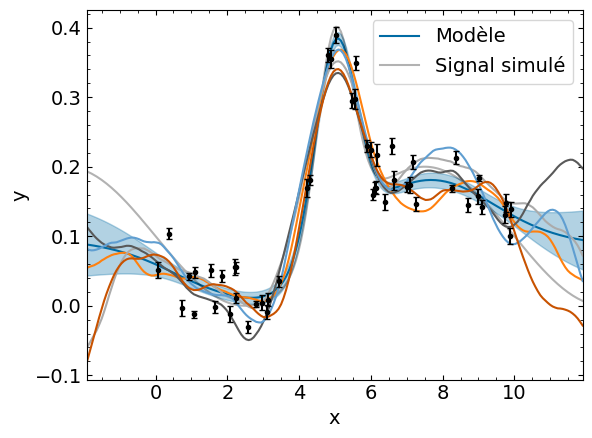

In [17]:
gp = build_gp(soln.params, X, yerr)
_, cond = gp.condition(y, X_test)

mu = cond.loc
std = np.sqrt(cond.variance)
samp = cond_gp.sample(jax.random.PRNGKey(33), shape=(5,))

plt.plot(X_test, mu, label="Modèle")
plt.plot(X_test, true_y, "k", lw=1.5, alpha=0.3, label="Signal simulé")
plt.fill_between(X_test, mu + std, mu - std, color="C0", alpha=0.3)
plt.plot(X_test, samp.T)
plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

Pas si mal! Par contre, difficile de voir ce qui vient du GP et ce qui vient de notre modèle gaussiens... Pour ce faire, on peut séparer les contributions de chaque terme.

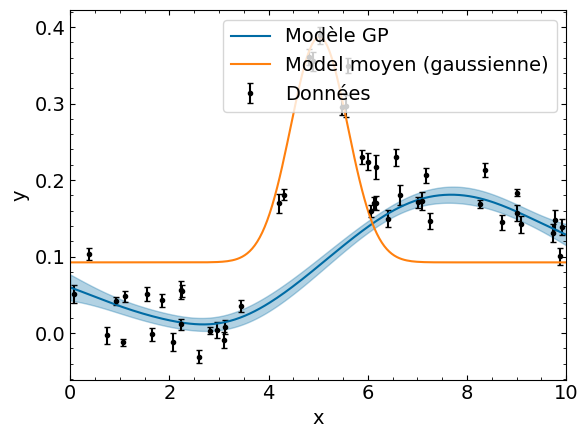

In [18]:
gp = build_gp(soln.params, X, yerr)
_, cond = gp.condition(y, X_grid, include_mean=False)

mu = cond.loc + soln.params["b"]
std = np.sqrt(cond.variance)

plt.errorbar(X, y, yerr=yerr, fmt="k.", label="Données", capsize=2)
plt.plot(X_grid, mu, label="Modèle GP")
plt.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
plt.plot(X_grid, jax.vmap(gp.mean_function)(X_grid), label="Model moyen (gaussienne)")

plt.xlim(X_grid.min(), X_grid.max())
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

## HMC avec Numpyro

Comme Jax nous donne automatiquement les gradients, il existe plusieurs librairies pour tirer avantage du HMC avec Jax.
L'une des plus communes est NumPyro, qui implémente plusieurs distriubtion et simplifie beaucoup la définition d'un modèle probabilistique.

In [19]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Utiliser 2 CPUs pour le MCMC (1 par chaîne)
numpyro.set_host_device_count(2)

def numpyro_model(X, yerr, y=None):
    # Definition de nos paramètres (priors).
    # Comme notre modèle utilise un dictionnaire, on place les distribution dans un dictionnaire
    params = dict(
        # Pour définir le prior sur un paramètre, on inclut son nom et une distribution numpyro.
        # En donnant ces objets au modèle, il sera possible de faire un MCMC avec numpyro par la suite
        log_gp_amp = numpyro.sample("log_gp_amp", dist.Uniform(np.log(1e-4), np.log(1))),
        log_gp_scale = numpyro.sample("log_gp_scale", dist.Uniform(np.log(1e-4), np.log(1e2))),
        log_gp_diag = numpyro.sample("log_gp_diag", dist.Uniform(np.log(1e-4), np.log(1))),
        a = numpyro.sample("a", dist.LogUniform(1e-4, 10)),
        b = numpyro.sample("b", dist.Uniform(-0.1, 0.5)),
        loc = numpyro.sample("loc", dist.Uniform(0, 10)),
        log_width = numpyro.sample("log_width", dist.Uniform(np.log(1e-1), np.log(10.0))),
    )
    
    # Définition du modèle GP en incluant les priors
    gp = build_gp(params, X, yerr)
    
    # Ceci fait office de likelihood. Tinygp implémente directement une distribution numpyro
    # En utilisant "obs=y", on échantillonne selon les observations.
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    
    # Il est intéressant de regarder la prédiction du GP à travers le sampling
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, X_test).gp.loc)

/home/vandal/repos/learning/tinygp-learn/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Numpyro utilise un "kernel" pour le MCMC, i.e. pour définir les propositions, un peu comme les "moves" emcee.
# Ici on utilise le No U-Turn Sampling, la version la plus commune du HMC.
nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
# On lance le MCMC avec 1000 warm-up (burn in) et 1000 échantillons. On utilise 2 chaines (2 walkers dans emcee). Par contre ici les chaines sont indépendantes.
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=2, progress_bar=True)

In [21]:
# Avec Jax, il faut générer explicitement les nombres aléatoires
rng_key = jax.random.PRNGKey(1111)
mcmc.run(rng_key, X, yerr, y=y)

Running chain 1: 100%|█████████████████████| 2000/2000 [01:09<00:00, 28.92it/s]


In [22]:
# On va ensuite chercher les échantillons
samples = mcmc.get_samples()
pred = samples["pred"]

Le MCMC est terminé. On a tout ce dont on a besoin pour estimer l'incertitude sur le GP.

### Visualisation
La librairie arviz permet de visualiser facilement un résumé des résultats et les statistiques associées.

In [23]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.285,0.046,0.218,0.357,0.003,0.002,878.0,353.0,1.0
b,0.103,0.088,-0.088,0.252,0.004,0.003,554.0,389.0,1.0
loc,5.010,0.307,4.915,5.129,0.011,0.007,1705.0,845.0,1.0
log_gp_amp,-4.454,1.235,-6.567,-2.235,0.063,0.044,408.0,595.0,1.0
log_gp_diag,-7.202,0.250,-7.663,-6.736,0.007,0.005,1248.0,824.0,1.0
log_gp_scale,1.281,0.486,0.348,2.190,0.025,0.018,383.0,384.0,1.0
log_width,-0.562,0.157,-0.767,-0.320,0.005,0.005,1573.0,732.0,1.0


Le "trace plot" montre les chaînes et la distribution poru chaque paramètre.

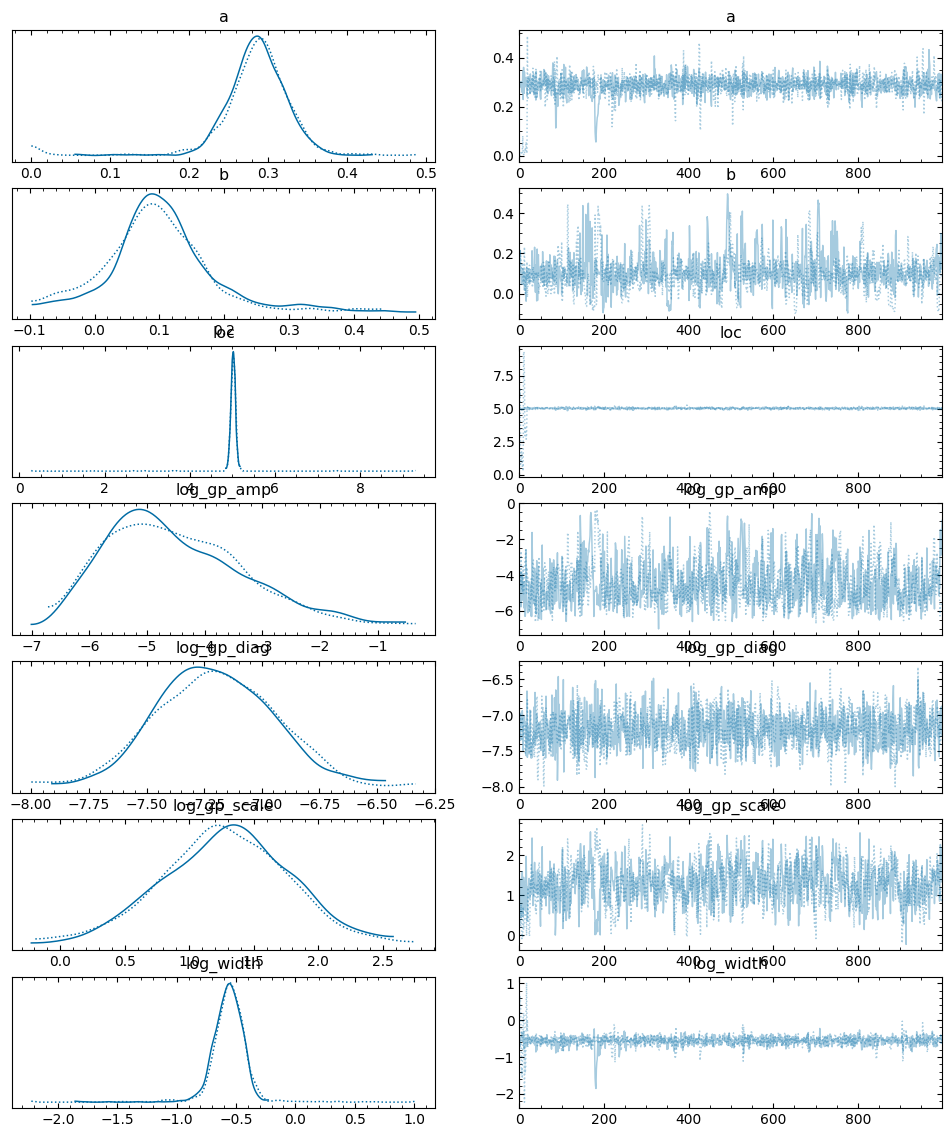

In [24]:
az.plot_trace(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"],
)
plt.show()

In [25]:
var_names=[v for v in data.posterior.data_vars if v != "pred"]
mean_params = {
    "a": 0.3,
    "b": 0.1,
    "loc": 5.0,
    "log_width": np.log(0.5),
}
true_params = {name: mean_params.get(name) for name in var_names}

Corner est compatible avec numpyro et arviz.

In [26]:
import corner

corner.corner(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"], truths=true_params,
)
plt.show()

ModuleNotFoundError: No module named 'corner'

In [ ]:
az.plot_autocorr(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)
plt.show()

In [ ]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(X_test, q[0], q[2], color="C0", alpha=0.5, label="2 $\sigma$")
plt.plot(X_test, q[1], color="C0", lw=2, label="Prédiction médiane")
plt.plot(X_test, true_y, "k", lw=1.5, alpha=0.3, label="Signal simulé")

plt.errorbar(X, y, yerr=yerr, fmt=".k", capsize=2)
plt.xlabel("x [day]")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend()
plt.title("Posterior MCMC")
plt.show()